# Coding Challenge: Gene Knockout Analysis with Embeddings - Task 3: Analyze the results of the In-Silico Perturbation Workflow to target ALS genes

In this notebook, we analyze the results of the in-silico knockup experiment that we performed in the previous notebook. 

In [1]:
%load_ext autoreload
%autoreload 2

## Load packages

In [2]:
import logging
import warnings

import os

import numpy as np
import pandas as pd

import scanpy as sc
import umap

import torch

import seaborn as sns
import matplotlib.pyplot as plt


/Users/marenbuettner/miniforge3/envs/helical/lib/python3.11/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [3]:
sc.logging.print_versions()

Package,Version
numpy,1.26.4
pandas,2.2.2
scanpy,1.11.5
umap-learn,0.5.9.post2
torch,2.6.0
seaborn,0.13.2
matplotlib,3.10.7
Component,Info
Python,"3.11.14 | packaged by conda-forge | (main, Oct 22 2025, 22:56:31) [Clang 19.1.7 ]"
OS,macOS-26.0.1-arm64-arm-64bit


Import custom code for perturbation and perturbation analysis.

In [4]:
from anndata_perturbation import AnnDataPerturbationModel
from perturbation_analysis import PerturbationAnalyzer

## Set paths and load data

In [5]:
project_path = './'
data_dir = os.path.join(project_path, "data")
table_dir = os.path.join(project_path, "tables")
figure_dir = os.path.join(project_path, "figures")
# set scanpy figure path in addition
sc.settings.figdir = os.path.join(project_path, "figures")
# load data in anndata format
adata = sc.read(os.path.join(project_path, data_dir, "counts_combined_filtered_BA4_sALS_PN.h5ad"))

Load perturbation predictions and data model from previous notebook.

In [6]:
import pickle

In [35]:
with open(os.path.join(data_dir, 'perturbmodel_1k_02.pkl'), 'rb') as handle:
    perturb_model = pickle.load(handle)

INFO:datasets:PyTorch version 2.6.0 available.


In [ ]:
with open(os.path.join(data_dir, 'perturbmodel_1k_batch_knockup.pkl'), 'rb') as handle:
    results_batch = pickle.load(handle)

In [8]:
with open(os.path.join(data_dir, 'perturbmodel_1k_pathway_knockup.pkl'), 'rb') as handle:
    result_pathway = pickle.load(handle)

## Analysis of the in-silico perturbation experiment

In the previous notebook, we have established a retionale for the in-silico perturbation experiments. Specifically, we performed knockup experiments for genes involved in the RNA metabolism (*TIA1, TARDBP, FUS*, and *C9orf72*), which are all linked to ALS via increased the integrated stress response (ISR) pathway. 

We performed single gene knockup perturbations and a pathway perturbation in addition. 

We analyze the results of the individual perturbations in the following.

In [24]:
genes_to_perturb = ['TIA1', 'TARDBP', 'FUS', 'C9orf72']

Concatenate the result objects for joint analysis.

In [27]:
results_batch['pathway'] = result_pathway

Create analysis object and show ranking of perturbations.

In [28]:
analyzer = PerturbationAnalyzer(results_batch)
rankings = analyzer.rank_by_effect_size(top_k=10, metric='cosine')


In [32]:
rankings

,gene,mean_distance,std_distance,median_distance,max_distance,n_cells
0,pathway,0.000182,0.000393,0.000116,0.009045,1000
1,C9orf72,0.000076,0.000424,0.000000,0.012815,1000
2,FUS,0.000075,0.000226,0.000018,0.005737,1000
3,TARDBP,0.000061,0.000149,0.000000,0.001760,1000
4,TIA1,0.000003,0.000027,0.000000,0.000538,1000


Note: From the overall effect size on this dataset, C9orf72 and FUS seem to have the strongest impact (strongest mean distance and median distance, respectively). However, the effects seem very small overall. The simulated change along the entire pathway has the strongest effect, but seems small as well.

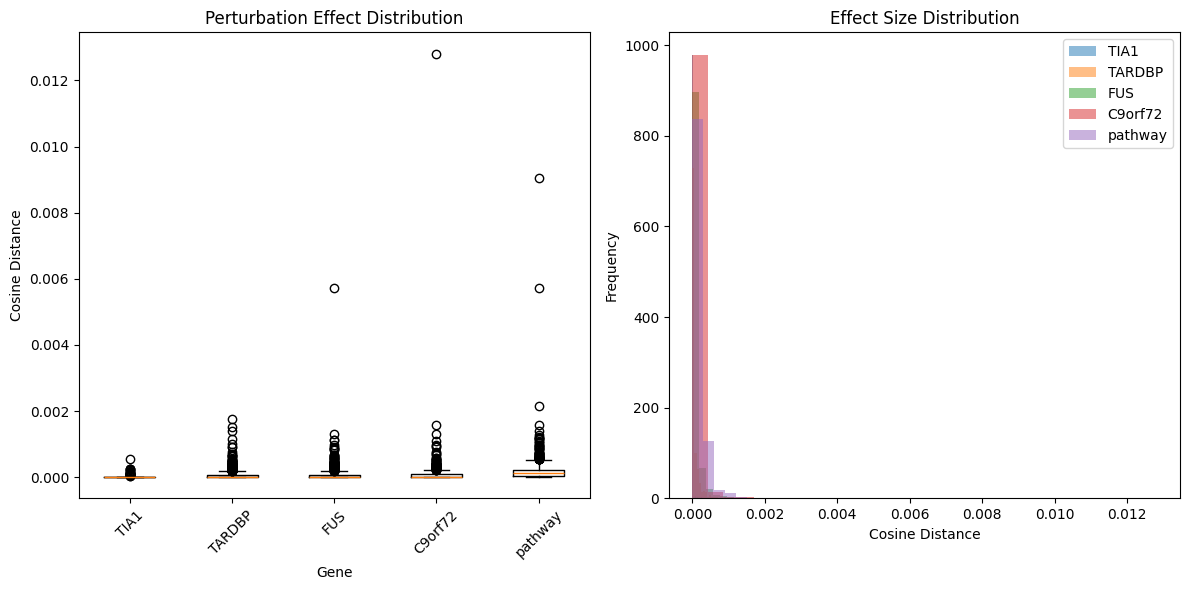

In [ ]:
fig = analyzer.plot_effect_distribution(metric='cosine')
plt.show()

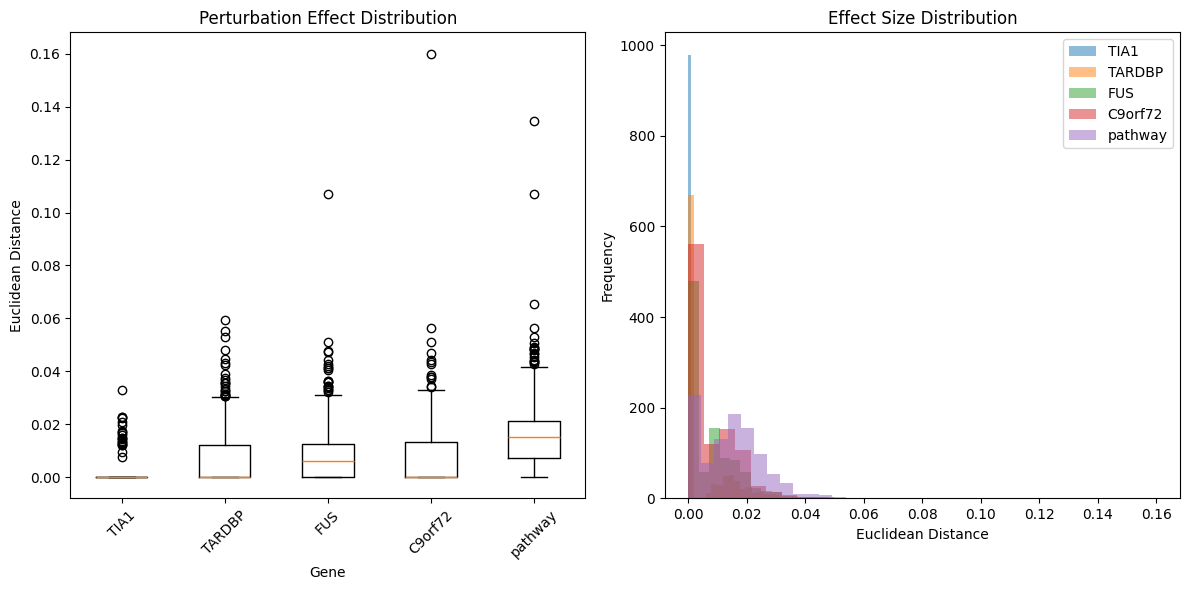

In [34]:
fig = analyzer.plot_effect_distribution(metric='euclidean')
plt.show()

Let us inspect the impact of the perturbation on a UMAP plot, one per perturbation.

/Users/marenbuettner/miniforge3/envs/helical/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/marenbuettner/miniforge3/envs/helical/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/marenbuettner/miniforge3/envs/helical/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/marenbuettner/miniforge3/envs/helical/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/marenbuettner/miniforge3/envs/helical/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


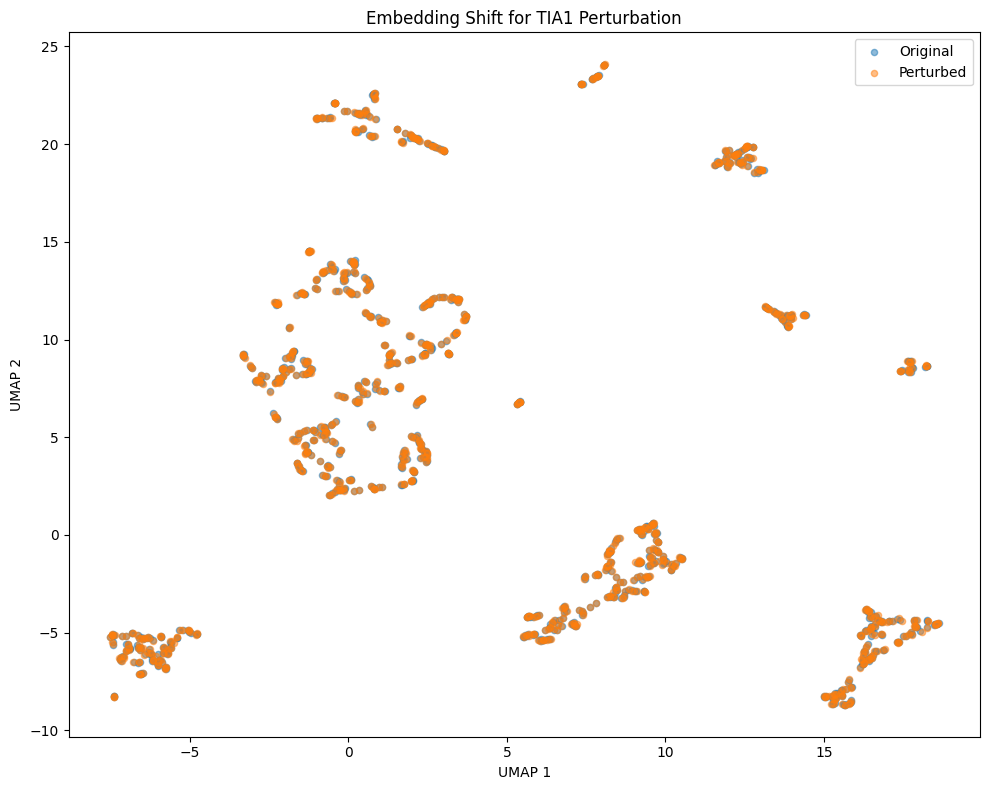

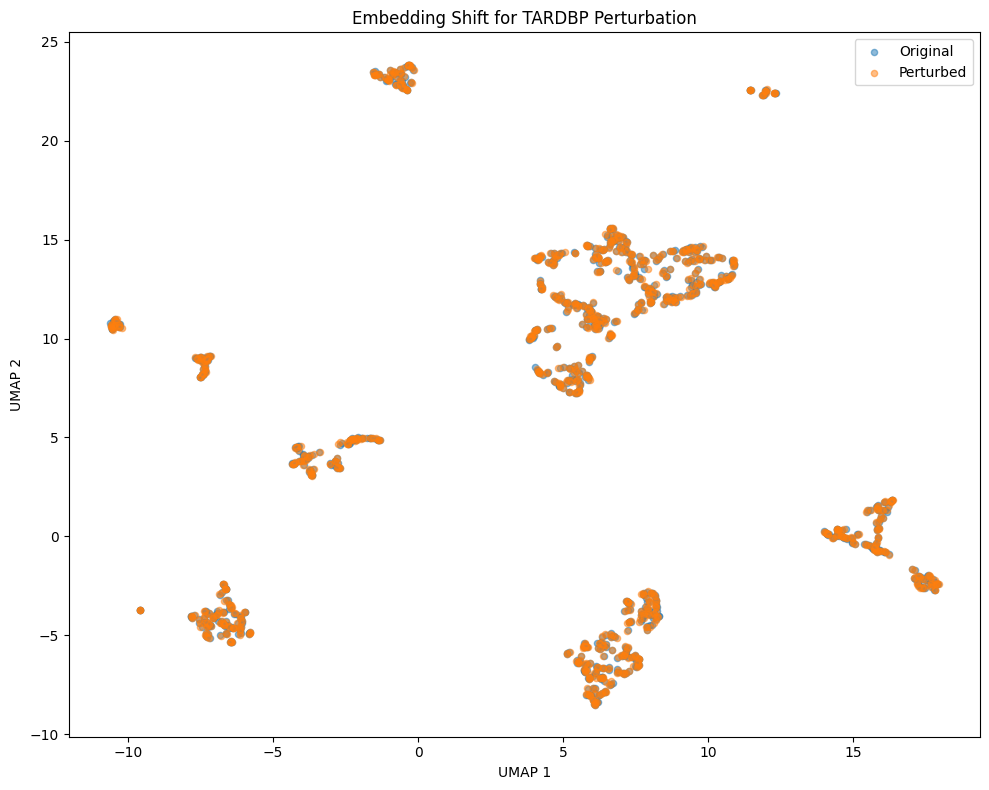

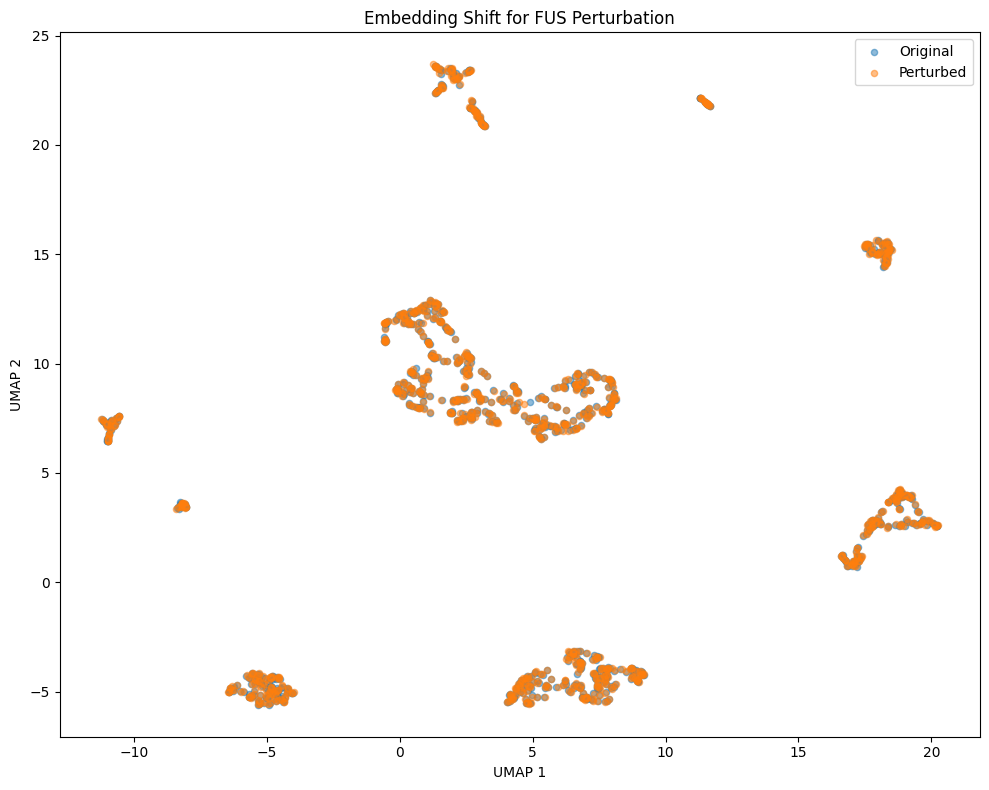

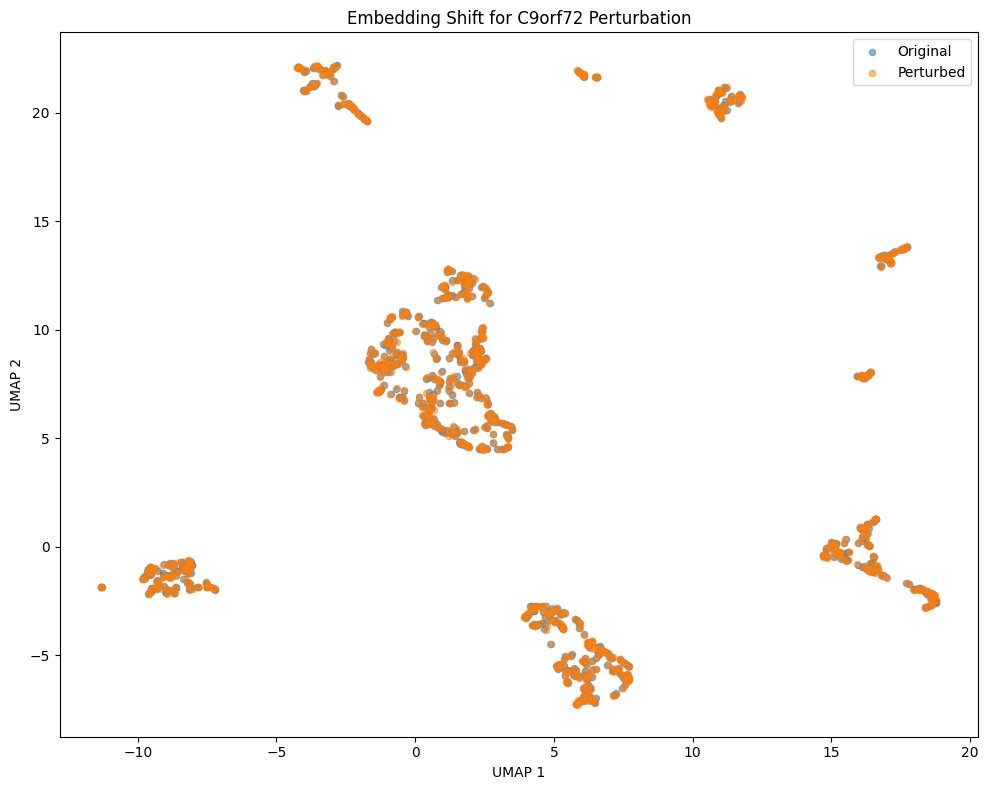

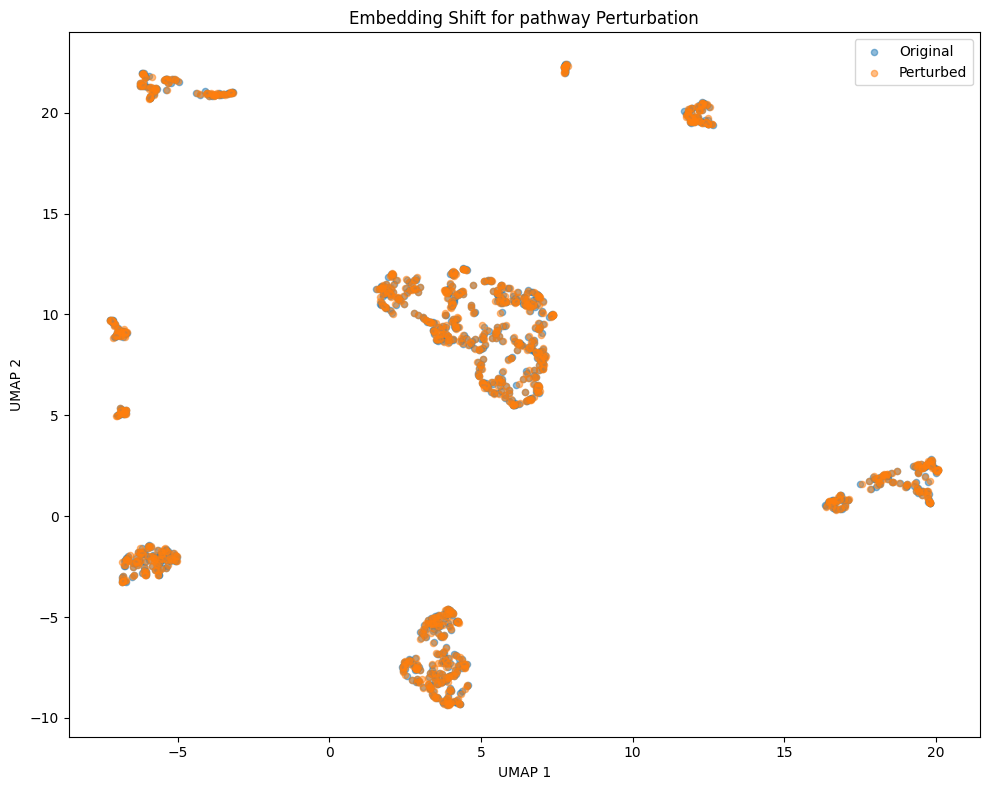

In [31]:
fig_list = []
for idx, gene in enumerate(genes_to_perturb + ['pathway']):
    fig_list.append(analyzer.plot_embedding_shift(gene=gene, method='umap', figsize=(10,8)))
plt.show()

Again, shifts seem relatively small on the UMAP, with no clear distinction per cluster (cell type).

Let us determine the shifts per cluster (cell type).

In [64]:
celltype = perturb_model.adata.obs['CellType'].cat.codes.tolist()
celltype_names = perturb_model.adata.obs['CellType'].tolist()

  warn(



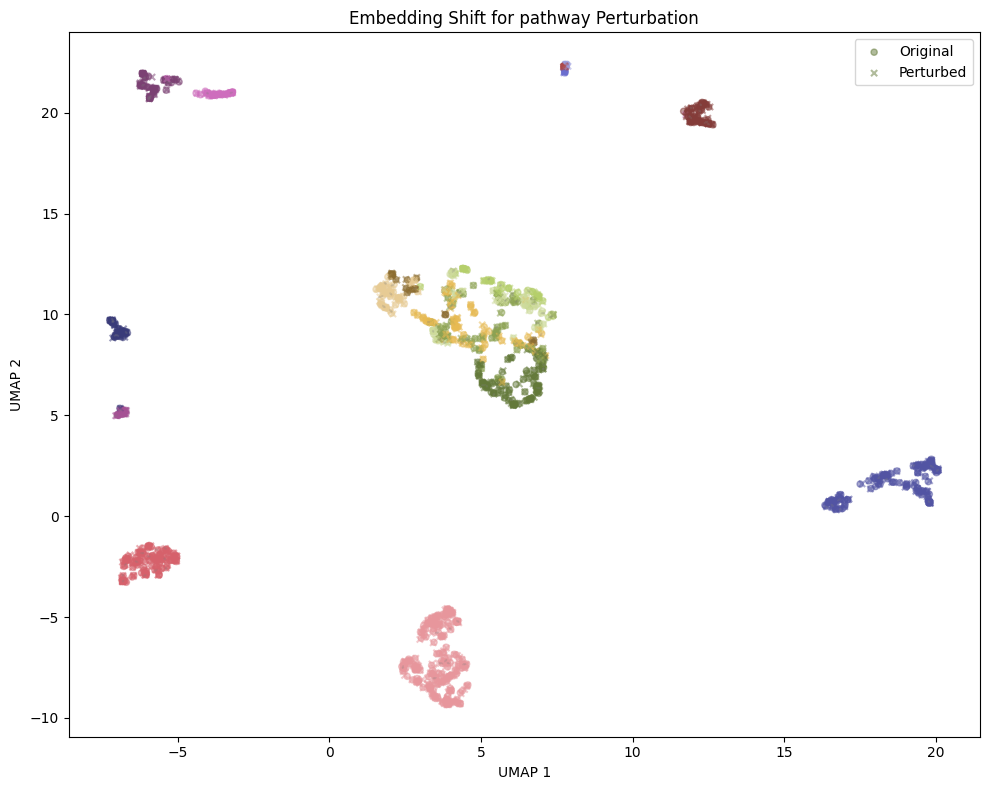

In [41]:
fig = analyzer.plot_embedding_shift(gene=gene, method='umap', color=celltype, figsize=(10,8))
plt.show()

In [65]:
distance_list = []
for gene in genes_to_perturb + ['pathway']:
    distance = results_batch[gene].compute_distances(metric='cosine')
    distance_list.append(pd.DataFrame(
        {gene : distance, 
         'celltype' : celltype_names}, 
        index = perturb_model.adata.obs_names).groupby('celltype').mean())

In [66]:
distance_by_cluster = distance_list[0].join(distance_list[1:])

In [67]:
distance_by_cluster.style.background_gradient(axis=None, vmin=0, vmax=5e-4, cmap='YlGnBu').format(precision=5)

,TIA1,TARDBP,FUS,C9orf72,pathway
celltype,,,,,
5HT3aR,0.00000,0.00004,0.00002,0.00003,0.00009
Astro,0.00001,0.00003,0.00008,0.00005,0.00015
Endo,-0.00000,0.00003,0.00003,0.00003,0.00008
Fibro,-0.00000,-0.00000,0.00004,0.00002,0.00006
L2_L3,0.00001,0.00012,0.00008,0.00023,0.00031
L3_L5,0.00000,0.00013,0.00010,0.00014,0.00028
L4_L5,0.00001,0.00008,0.00007,0.00007,0.00021
L4_L6,0.00000,0.00010,0.00011,0.00010,0.00029
L5,-0.00000,0.00011,0.00017,0.00009,0.00030


The table above illustrates the mean shift per cell type in each of the perturbations on healthy cells when we double the expression of genes in the RNA metabolism pathway. Both *TARDBP* and *C9orf72* seem to affect L2_L3 and L3_L5 upper motor neurons (UMNs) the strongest, while *TIA1* did not seem to affect any of the cell types in particular. *FUS* overexpression affects L5 UMNs and PV inhibitory neurons the strongest. The perturbation of all four RNA metabolism genes predicts the strongest changes in L2 - L6 UMNs as well as neocortical inhibitory neurons (PV, Rosehip and SOM) and a slightly smaller change in astrocytes as well. 

Lastly, let us determined the mixing of individual neighborhoods through neighborhood analysis.

In [70]:
for gene in genes_to_perturb + ['pathway']:
    # Quick check - single mixing score
    mixing = results_batch[gene].compute_mixing_score(k=15)
    print(f"Mixing in {gene}: {mixing:.3f}")  # > 0.8 = weak, < 0.5 = strong

Mixing in TIA1: 0.933
Mixing in TARDBP: 0.929
Mixing in FUS: 0.928
Mixing in C9orf72: 0.929
Mixing in pathway: 0.923


In [78]:
bias_list = []
alpha = 0.05

for gene in genes_to_perturb + ['pathway']:
    # Detailed statistical analysis
    bias_result = results_batch[gene].test_neighborhood_bias(k=15)
    print(f"Significant cells: {bias_result['summary']['pct_significant']:.1f}%")
    print(f"Original-biased: {bias_result['n_original_biased']}")
    print(f"Perturbed-biased: {bias_result['n_perturbed_biased']}")

    # Per-cell detailed analysis
    detailed = results_batch[gene].test_neighborhood_bias(k=15, return_all_cells=True)
    bias_list.append(pd.DataFrame(
        {gene : detailed['p_values']<alpha, 
         'celltype' : celltype_names + celltype_names}, 
        index = range(len(detailed['p_values'])) ).groupby('celltype').mean())

Significant cells: 0.0%
Original-biased: 0
Perturbed-biased: 0
Significant cells: 0.0%
Original-biased: 0
Perturbed-biased: 0
Significant cells: 0.0%
Original-biased: 0
Perturbed-biased: 0
Significant cells: 0.0%
Original-biased: 0
Perturbed-biased: 0
Significant cells: 0.0%
Original-biased: 0
Perturbed-biased: 0


In [79]:
bias_by_cluster = bias_list[0].join(bias_list[1:])

In [80]:
bias_by_cluster.style.background_gradient(axis=None, vmin=0, vmax=5e-4, cmap='YlGnBu').format(precision=5)

,TIA1,TARDBP,FUS,C9orf72,pathway
celltype,,,,,
5HT3aR,0.00000,0.00000,0.00000,0.00000,0.00000
Astro,0.00000,0.00000,0.00000,0.00000,0.00000
Endo,0.00000,0.00000,0.00000,0.00000,0.00000
Fibro,0.00000,0.00000,0.00000,0.00000,0.00000
L2_L3,0.00000,0.00000,0.00000,0.00000,0.00000
L3_L5,0.00000,0.00000,0.00000,0.00000,0.00000
L4_L5,0.00000,0.00000,0.00000,0.00000,0.00000
L4_L6,0.00000,0.00000,0.00000,0.00000,0.00000
L5,0.00000,0.00000,0.00000,0.00000,0.00000


Overall, the neighborhoods for all cell types appear very well mixed, which underscores the low impact of the perturbation overall. For a stronger change, we would have expected that perturbed cells group with other perturbed cells. It is worth noting that we only looked at healthy cells here, while the dataset also contains diseased cells, an extension to the analysis would be to compare the perturbed cells to the diseased cells. 

As a conclusion, we do observe small changes by overexpressing genes of the RNA metabolism pathway, but the changes are small and almost indistinguishable from healthy cells. Further experiments, for instance using a stronger foldchange factor, or perturbing diseased cells could lead to more insights on the impact of RNA metabolism genes on disease progression of ALS.  

End of the workflow.